# Prompting on Liar Dataset

## Dataset Setup

In [1]:
import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"]="expandable_segments:True"

In [2]:
import datasets

# covid-19 section of 
# @misc{patwa2020fighting,
# title={Fighting an Infodemic: COVID-19 Fake News Dataset}, 
# author={Parth Patwa and Shivam Sharma and Srinivas PYKL and Vineeth Guptha and Gitanjali Kumari and Md Shad Akhtar and Asif Ekbal and Amitava Das and Tanmoy Chakraborty},
# year={2020},
# eprint={2011.03327},
# archivePrefix={arXiv},
# primaryClass={cs.CL}
# }

ds = datasets.load_dataset("nanyy1025/covid_fake_news")
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'tweet', 'label'],
        num_rows: 6420
    })
    validation: Dataset({
        features: ['id', 'tweet', 'label'],
        num_rows: 2140
    })
    test: Dataset({
        features: ['id', 'tweet', 'label'],
        num_rows: 2140
    })
})

In [3]:
train = ds["train"]
test = ds["test"]
val = ds["validation"]

In [4]:
ds = datasets.concatenate_datasets([train, test, val])
ds

/home/016854656/miniconda3/envs/torch/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Dataset({
    features: ['id', 'tweet', 'label'],
    num_rows: 10700
})

## Model Loading

In [5]:
falcon = "tiiuae/falcon-7b-instruct"
llama = "meta-llama/Llama-2-7b-chat-hf"
mistral = "mistralai/Mistral-7B-Instruct-v0.2"
orca = "microsoft/Orca-2-7b"
gemma = "google/gemma-7b-it"

In [6]:
# change this depending on experiment
model_name = llama

In [7]:
mistral_device_map = {'model.embed_tokens': 0,
 'model.layers.0': 0,
 'model.layers.1': 0,
 'model.layers.2': 0,
 'model.layers.3': 0,
 'model.layers.4': 0,
 'model.layers.5': 0,
 'model.layers.6': 0,
 'model.layers.7': 0,
 'model.layers.8': 0,
 'model.layers.9': 0,
 'model.layers.10': 0,
 'model.layers.11': 0,
 'model.layers.12': 0,
 'model.layers.13': 0,
 'model.layers.14': 0,
 'model.layers.15': 0,
 'model.layers.16': 0,
 'model.layers.17': 0,
 'model.layers.18': 0,
 'model.layers.19': 0,
 'model.layers.20': 1,
 'model.layers.21': 1,
 'model.layers.22': 1,
 'model.layers.23': 1,
 'model.layers.24': 1,
 'model.layers.25': 1,
 'model.layers.26': 1,
 'model.layers.27': 1,
 'model.layers.28': 1,
 'model.layers.29': 1,
 'model.layers.30': 1,
 'model.layers.31': 1,
 'model.norm': 1,
 'lm_head': 1}

In [8]:
gemma_device_map = {'model.embed_tokens': 0,
 'lm_head': 0,
 'model.layers.0': 0,
 'model.layers.1': 0,
 'model.layers.2': 0,
 'model.layers.3': 0,
 'model.layers.4': 0,
 'model.layers.5': 0,
 'model.layers.6': 0,
 'model.layers.7': 0,
 'model.layers.8': 0,
 'model.layers.9': 0,
 'model.layers.10': 0,
 'model.layers.11': 0,
 'model.layers.12': 0,
 'model.layers.13': 0,
 'model.layers.14': 0,
 'model.layers.15': 0,
 'model.layers.16': 0,
 'model.layers.17': 1,
 'model.layers.18': 1,
 'model.layers.19': 1,
 'model.layers.20': 1,
 'model.layers.21': 1,
 'model.layers.22': 1,
 'model.layers.23': 1,
 'model.layers.24': 1,
 'model.layers.25': 1,
 'model.layers.26': 1,
 'model.layers.27': 1,
 'model.norm': 0}

In [9]:
llama_device_map= {'model.embed_tokens': 0,
 'model.layers.0': 0,
 'model.layers.1': 0,
 'model.layers.2': 0,
 'model.layers.3': 0,
 'model.layers.4': 0,
 'model.layers.5': 0,
 'model.layers.6': 0,
 'model.layers.7': 0,
 'model.layers.8': 0,
 'model.layers.9': 0,
 'model.layers.10': 0,
 'model.layers.11': 0,
 'model.layers.12': 0,
 'model.layers.13': 0,
 'model.layers.14': 0,
 'model.layers.15': 0,
 'model.layers.16': 0,
 'model.layers.17': 0,
 'model.layers.18': 1,
 'model.layers.19': 1,
 'model.layers.20': 1,
 'model.layers.21': 1,
 'model.layers.22': 1,
 'model.layers.23': 1,
 'model.layers.24': 1,
 'model.layers.25': 1,
 'model.layers.26': 1,
 'model.layers.27': 1,
 'model.layers.28': 1,
 'model.layers.29': 1,
 'model.layers.30': 1,
 'model.layers.31': 1,
 'model.norm': 1,
 'lm_head': 1}

In [10]:
device_map = {
    llama: llama_device_map,
    mistral: mistral_device_map,
    gemma: gemma_device_map,
    falcon: "auto",
    orca: "auto"
}

In [11]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# torch.backends.cuda.matmul.allow_tf32 = True

config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=config)
# model = AutoModelForCausalLM.from_pretrained(
#     model_name, device_map=device_map[model_name], torch_dtype = torch.bfloat16 # quantization_config=config, 
# )


`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are calling `save_pretrained` to a 4-bit converted model, but your `bitsandbytes` version doesn't support it. If you want to save 4-bit models, make sure to have `bitsandbytes>=0.41.3` installed.


## Experiment

### Experiment Utils

In [12]:
from transformers import PreTrainedTokenizer
from typing import Dict

LABEL_MAP = {
    "real":["A", "True"],
    "fake":["B", "False"]
}


def was_correct(
    decoded:str, entry: Dict[str, int]
) -> bool:
    return any(map(lambda el: el.lower() in decoded.lower(), LABEL_MAP[entry["label"]]))

In [13]:
n_examples = 0

In [14]:
ds.features

{'id': Value(dtype='int64', id=None),
 'tweet': Value(dtype='string', id=None),
 'label': Value(dtype='string', id=None)}

In [15]:
ds[0]

{'id': 1,
 'tweet': 'The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today.',
 'label': 'real'}

In [16]:
import random
random.seed(1770)
entries = random.choices(list(range(len(ds))), k=n_examples)
MAX_LEN=256

def to_zero_shot_prompt(entry: Dict[str, str]) -> str:
    prompt = f"""Please select the option (A or B) that most closely describes the following claim: {entry['tweet'][:MAX_LEN]}\n\n(A) True\n(B) False\n\nChoice: ("""
    return prompt

def to_n_shot_prompt(n: int, entry: Dict[str, str]) -> str:
    examples = ""
    for i in range(n):
        examples += to_zero_shot_prompt(ds[entries[i]]) + LABEL_MAP[ds[entries[i]]['label']] + "\n\n"
    prompt = to_zero_shot_prompt(entry)
    return examples + prompt

In [17]:
responses: Dict[str, list] = {}

def workflow(idx:int, entry: dict, model, k:int=0, verbose: bool = False) -> bool:
    # encode input, move it to cuda, then generate
    encoded_input = tokenizer(entry['prompt'], return_tensors="pt")
    encoded_input = {item: val.cuda() for item, val in encoded_input.items()}
    generation = model.generate(
        **encoded_input,
        max_new_tokens=1,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id
    )

    # log the prompt and response if verbose
    if verbose:
        print(tokenizer.batch_decode(generation)[0])

    decoded = tokenizer.decode(generation[0, -1])
    correct = was_correct(decoded, entry)
    
    if decoded not in responses:
        responses[decoded] = []
    responses[decoded].append(idx)

    if verbose:
        print(
            "The model was",
            "correct" if correct else "incorrect",
            " - responded",
            tokenizer.decode(generation[0, -1]),
            "and answer should have been",
            LABEL_MAP[entry["label"]],
        )
    return correct

### Verify it works

In [18]:
ds = ds.map(lambda e: {"prompt":to_n_shot_prompt(n_examples, e)})
ds

Dataset({
    features: ['id', 'tweet', 'label', 'prompt'],
    num_rows: 10700
})

In [19]:
import random
workflow(0, ds[random.randint(0, len(ds) - 1)], model, verbose=True, k=n_examples)

<s> Please select the option (A or B) that most closely describes the following claim: #PublicHealthReports has announced a Call for Papers on #COVID19 inviting #publichealth practitioners and academic researchers to share challenges lessons learned and opportunities for public health practice. Learn more here: https://t.co/mhm9gxCn3o. https

(A) True
(B) False

Choice: (A
The model was correct  - responded A and answer should have been ['A', 'True']


True

In [20]:
responses = {}

### Run Experiment

Results of zero-shot prompting the models

In [21]:
dl = torch.utils.data.DataLoader(ds, batch_size=8)

In [22]:
responses: Dict[str, list] = {}

# def batched_was_correct(decoded, entry):
#     tensored = 

def workflow_batch(idx:int, entry: dict, model, verbose: bool = False) -> bool:
    # encode input, move it to cuda, then generate
    encoded_input = tokenizer(entry['prompt'], return_tensors="pt", padding='max_length')
    encoded_input = {item: val.cuda() for item, val in encoded_input.items()}
    generation = model.generate(
        **encoded_input,
        max_new_tokens=1,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id,
    )

    # log the prompt and response if verbose
    if verbose:
        print(tokenizer.batch_decode(generation)[0])

    decoded = tokenizer.decode(generation[:, -1])
    correct = was_correct(decoded, entry)
    
    if decoded not in responses:
        responses[decoded] = []
    responses[decoded].append(idx)

    if verbose:
        print(
            "The model was",
            "correct" if correct else "incorrect",
            " - responded",
            tokenizer.decode(generation[0, -1]),
            "and answer should have been",
            LABEL_MAP[entry["label"]],
        )
    return correct

In [23]:
from tqdm import tqdm

num_correct = 0
responses={}
for idx, entry in enumerate((prog:=tqdm(ds))):
    if idx in entries:
        continue  # don't include items that were in the examples
    
    correct = workflow(idx, entry, model, k=n_examples)
    if correct:
        num_correct += 1
    prog.set_postfix_str(f"acc: {num_correct/(idx+1):.3f}")

 41%|██████████▋               | 4383/10700 [10:31<15:12,  6.92it/s, acc: 0.583]

In [ ]:
responses.keys()

dict_keys(['A', 'C', 'B', 'I', 'a', 'Y', 'true', 'V', 'True', '1', 'None', 'c', 'False', 'Q', '\n', 'b', 'ABC', 'd', 'i', '4', 'Choose', 'N', '3', 'false', 'Un', 'D', 'India', '2', 'XP', 'Select', 'Don', ' true', 'Answer', 'TRUE', 'T', ' A', 'P', 'Yes', 'M', 'G', ' ', 'View', 'or', 'O', 'E', 'Enter', 'X', 'exp', '0', 'Option', 'select', 'F', '9', 'Ex', 'https', 'g', 's', 'BC', '<|endoftext|>', 'BB', 'The', 'AG', 'In', ' B', 'AB', 'An', ' True', 'h', 'Ed', 'UP'])

In [ ]:
import seaborn as sns
import pandas as pd
sns.set_context("paper")


df = {"labels":[]}
for key, val in responses.items():
    df['labels'].extend([key]*len(val))
df = pd.DataFrame.from_dict(df)

<Axes: xlabel='labels', ylabel='count'>

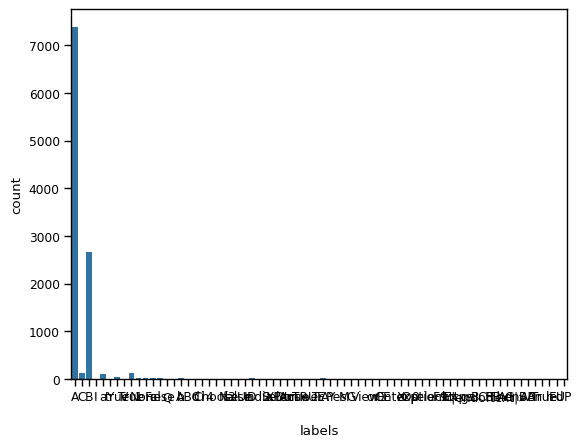

In [ ]:
sns.countplot(df, x='labels')

Text(0.5, 1.0, 'tiiuae/falcon-7b-instruct 0-shot')

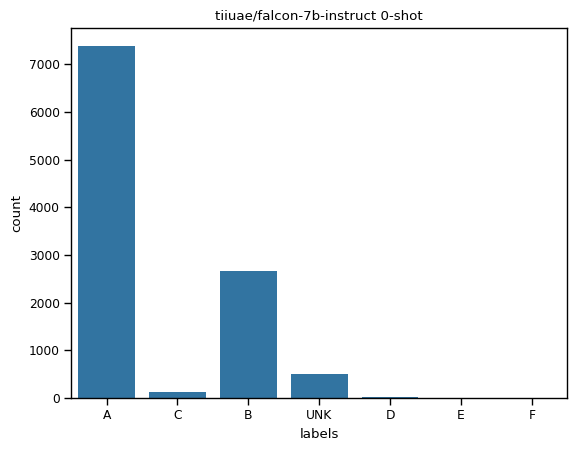

In [ ]:
accepted = ['A', 'B', 'C', 'D', 'E','F']
filtered = df.map(lambda val: val if val in accepted else 'UNK')
sns.countplot(filtered, x='labels', ).set_title(f"{model_name} 0-shot")

In [ ]:
import pickle
pickle.dump(responses, open(f"{model_name[model_name.index('/')+1:]}_{n_examples}responses.pk", "wb"))

In [ ]:
# log results
with open(f"{n_examples}_shot.txt", "a") as file:
    file.write(f"{model_name} : {num_correct}/{len(ds)-len(entries)}\n")

In [ ]:
# print results up till now
with open(f"{n_examples}_shot.txt", "r") as file:
    print(file.read())

meta-llama/Llama-2-7b-chat-hf : 2587/12836
tiiuae/falcon-7b-instruct : 2485/12836
mistralai/Mistral-7B-Instruct-v0.2 : 2849/12836
microsoft/Orca-2-7b : 2132/12836
tiiuae/falcon-7b-instruct : 2482/12836
mistralai/Mistral-7B-Instruct-v0.2 : 2857/12836
mistralai/Mistral-7B-Instruct-v0.2 : 2857/12836
microsoft/Orca-2-7b : 2131/12836

# 16 bit
meta-llama/Llama-2-7b-chat-hf : 2444/12836
tiiuae/falcon-7b-instruct : 1749/12836
mistralai/Mistral-7B-Instruct-v0.2 : 2871/12836
microsoft/Orca-2-7b : 2428/12836

# Covid
mistralai/Mistral-7B-Instruct-v0.2 : 8640/10700
tiiuae/falcon-7b-instruct : 5320/10700

